## https://medium.com/ai-academy-taiwan/explain-your-machine-learning-model-by-shap-part-1-228fb2a57119

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost
import matplotlib.pyplot as plt
from IPython.display import Image

## read data & split train & test

In [21]:
data = pd.read_csv("D:\python\FIFA 2018 Statistics.csv")
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=9487)

## Set xgb parameters


In [22]:
params = {'base_score': 0.5,
         'booster': 'gbtree',
         'colsample_bylevel': 1,
         'colsample_bytree': 1,
         'gamma': 0,
         'learning_rate': 0.05,
         'max_delta_step': 0,
         'max_depth': 3,
         'min_child_weight': 1,
         'missing': None,
         'n_estimators': 200,
         'n_jobs': 1,
         'objective': 'binary:logistic',
         'random_state': 0,
         'reg_alpha': 0,
         'reg_lambda': 1,
         'scale_pos_weight': 1,
         'seed': 0,
         'silent': True,
         'subsample': 1}

params['eval_metric'] = 'auc'

In [23]:
d_train = xgboost.DMatrix(X_train, y_train)
d_val = xgboost.DMatrix(X_val, y_val)
watchlist = [(d_train, "train"), (d_val, "valid")]

#train model

model = xgboost.train(params, d_train, num_boost_round=2000, evals=watchlist, early_stopping_rounds=100, verbose_eval=10) 

[0]	train-auc:0.822406	valid-auc:0.847059
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.862136	valid-auc:0.872549
[20]	train-auc:0.901867	valid-auc:0.894118
[30]	train-auc:0.919019	valid-auc:0.894118
[40]	train-auc:0.935953	valid-auc:0.890196
[50]	train-auc:0.950065	valid-auc:0.894118
[60]	train-auc:0.958315	valid-auc:0.882353
[70]	train-auc:0.967	valid-auc:0.882353
[80]	train-auc:0.969605	valid-auc:0.870588
[90]	train-auc:0.976552	valid-auc:0.854902
[100]	train-auc:0.986105	valid-auc:0.835294
[110]	train-auc:0.990881	valid-auc:0.827451
[120]	train-auc:0.995658	valid-auc:0.819608
[130]	train-auc:0.998263	valid-auc:0.807843
[140]	train-auc:1	valid-auc:0.823529
Stopping. Best iteration:
[46]	train-auc:0.944855	valid-auc:0.913725



In [24]:
# 簡單 check 一下 model 跑出來的東西
data_for_prediction = xgboost.DMatrix(X_train.iloc[[83],:])  # use 1 row of data here. Could use multiple rows if desired
model.predict(data_for_prediction)

array([0.13960385], dtype=float32)

In [25]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)
shap.initjs()

In [1]:
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

NameError: name 'pyplot' is not defined

## global interpretability

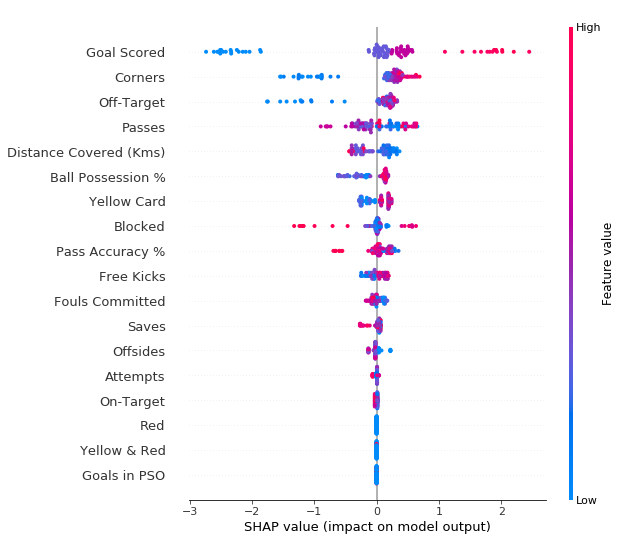

In [26]:
shap.summary_plot(shap_values, X_train)

## Local interpretability

In [67]:
data_for_prediction = xgboost.DMatrix(X_train.iloc[[10],:])  # use 1 row of data here. Could use multiple rows if desired
print(f"第85筆 data 預測為 True 的probability: {model.predict(data_for_prediction)}")
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:], show=False,matplotlib=True)
#import matplotlib.pyplot as pl
#f = pl.gcf()
#f.savefig('pig.png')

## shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:], show=False,matplotlib=True) .savefig('scratch.png')

第85筆 data 預測為 True 的probability: [0.88775516]


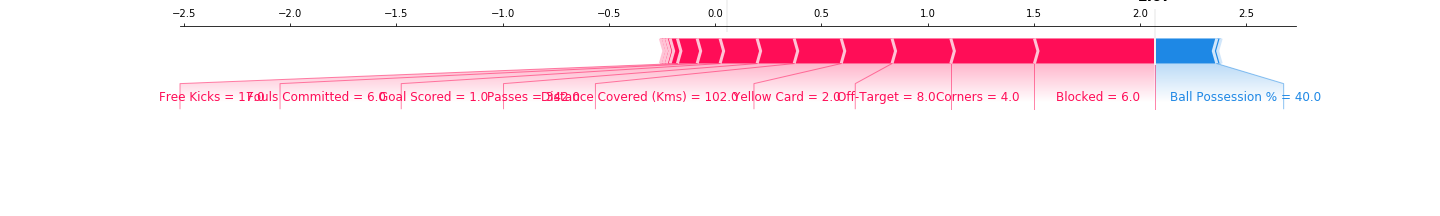

In [61]:
#上面cell的圖!
Image(filename="pig.png", width = 1000, height = 900)

In [29]:
data_for_prediction = xgboost.DMatrix(X_train.iloc[[83],:])  # use 1 row of data here. Could use multiple rows if desired
print(f"第83筆 data 預測為 True 的probability: {model.predict(data_for_prediction)}")
shap.force_plot(explainer.expected_value, shap_values[83,:], X_train.iloc[83,:])


第83筆 data 預測為 True 的probability: [0.13960385]


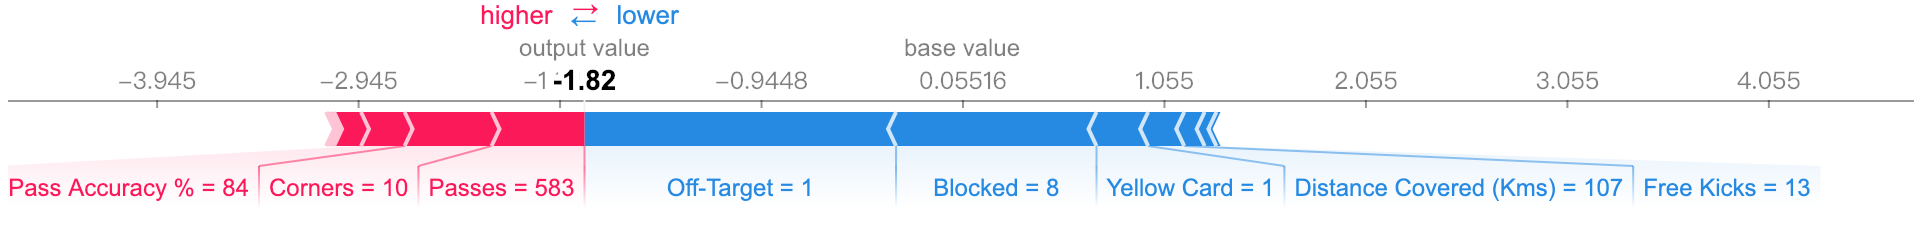

In [10]:
#上面cell的圖!
Image(filename="img/img_03.png", width = 800, height = 600)

## 解釋 output value 的作用

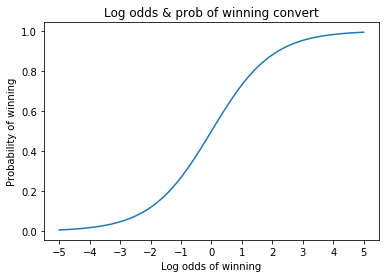

In [11]:
xs = np.linspace(-5,5,100)
plt.xlabel("Log odds of winning")
plt.ylabel("Probability of winning")
plt.title("Log odds & prob of winning convert")
plt.plot(xs, 1/(1+np.exp(-xs)))

new_ticks = np.linspace(-5, 5, 11)
plt.xticks(new_ticks)
plt.show()

## aggregated force_plot

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

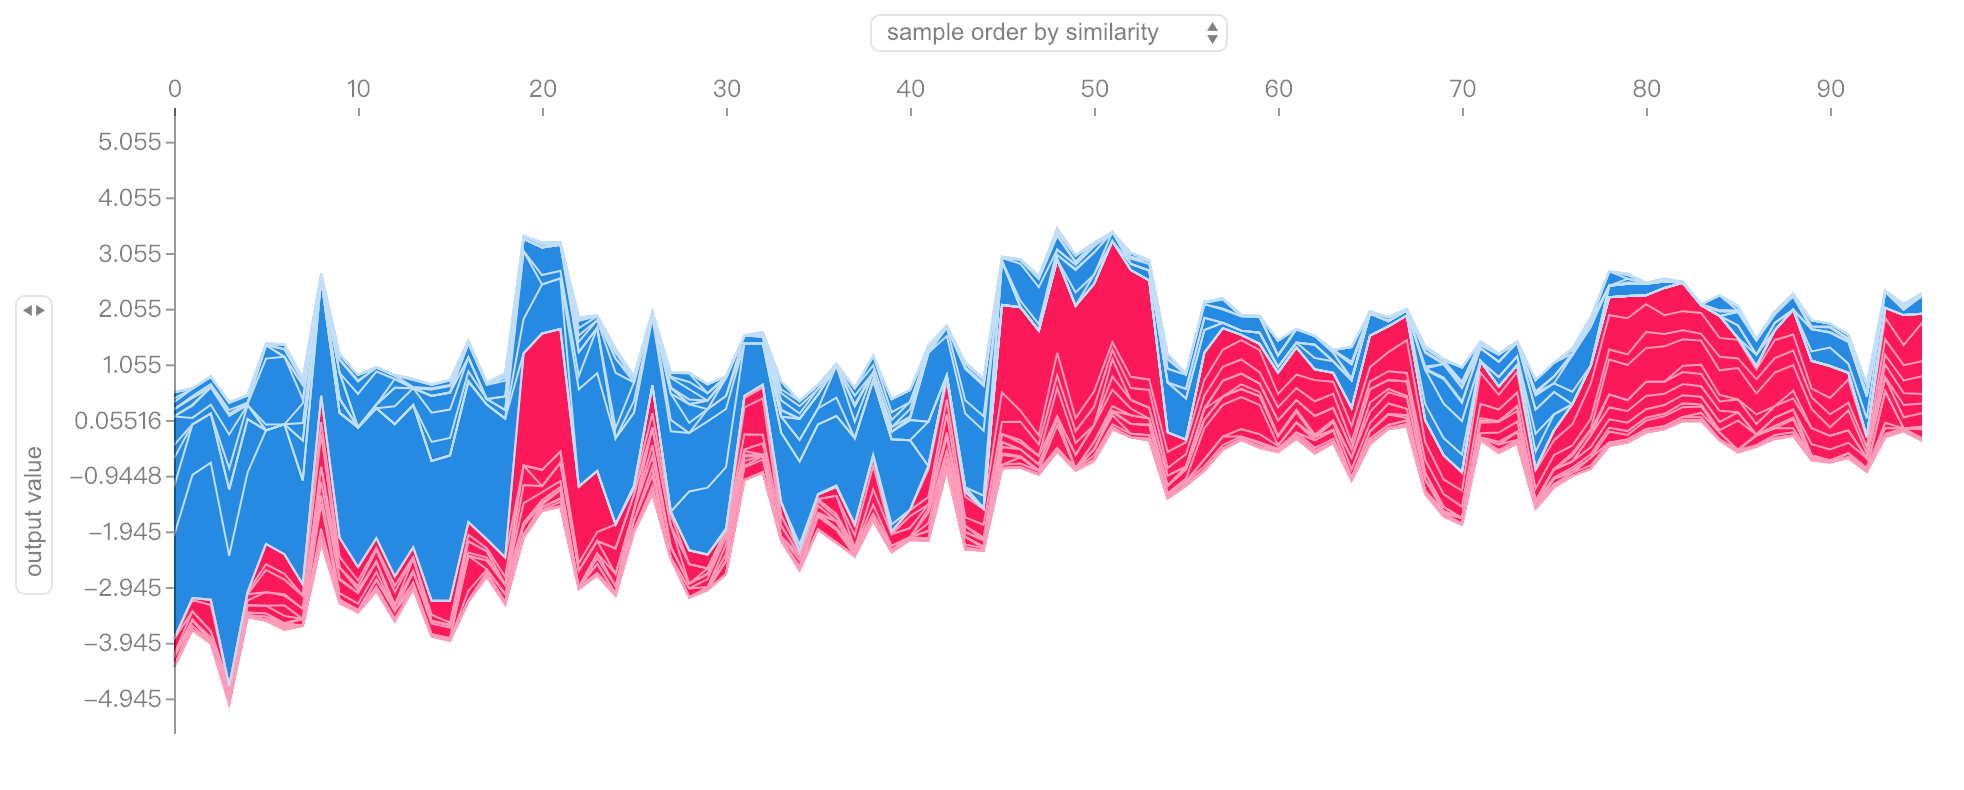

In [12]:
#上面cell的圖!
Image(filename="img/img_04.png", width = 900, height = 600)

## dependence_plot

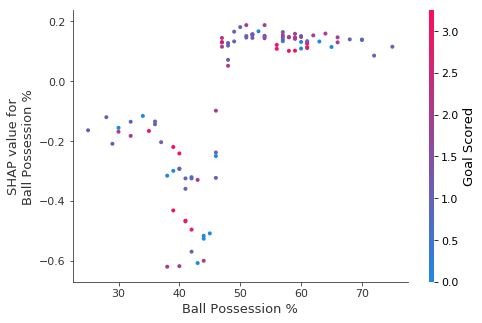

In [13]:
shap.dependence_plot('Ball Possession %', shap_values, X_train, interaction_index="Goal Scored")